### 1. Setup

* First, set up Python, numpy, and matplotlib.

In [20]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load caffe.

In [2]:
# The caffe module needs to be on the Python path;
# we'll add it here explicitly.
import sys
caffe_root = '/opt/caffe-cpu/'
sys.path.insert(0, caffe_root + 'python')

import caffe

# import opencv2 library; we'll need it to detect the face.
import cv2

### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk

In [3]:
caffe.set_mode_cpu()

model_def = '/home/superuser/pfe/vgg16_training/test_fold_is_0/vgg16_trig_run2/age.prototxt'
model_weights = '/home/superuser/pfe/vgg16_training/test_fold_is_0/vgg16_trig_run2/vgg16_adience_trig_run2_iter_13200.caffemodel'

net = caffe.Net(model_def,
                model_weights,
                caffe.TEST)

* Convert mean image from protobuf format to numpy array

In [4]:
blob = caffe.proto.caffe_pb2.BlobProto()
data = open( '../adience_mean/Test_fold_is_0/mean.binaryproto' , 'rb' ).read()
blob.ParseFromString(data)
arr = np.array( caffe.io.blobproto_to_array(blob) )
out = arr[0]
np.save( 'mean_fold0.npy' , out )

In [5]:
# load the mean ImageNet image for substraction
mu = np.load('mean_fold0.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-substracted values', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)  # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-substracted values [('B', 79.55780086456798), ('G', 89.210799906984903), ('R', 117.1146897651488)]


### 3. CPU classification

In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 227x227

In [ ]:
# you can download an image from url
my_image_url = "https://upload.wikimedia.org/wikipedia/commons/6/6f/Einstein-formal_portrait-35.jpg"
!wget -O image.jpg $my_image_url

In [7]:
im_file = 'my_family.jpg'
face_cascade = cv2.CascadeClassifier('../python/haarcascade_frontalface_default.xml')
img = cv2.imread(im_file)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# only consider the first face detected
(x,y,w,h) = faces[0]
cv2.imwrite('tmp.jpg', img[y:y+h, x:x+w])
cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

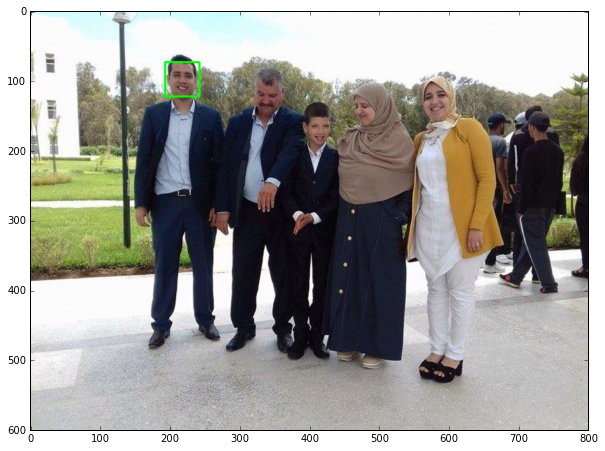

In [8]:
plt.imshow(img[:,:,::-1])

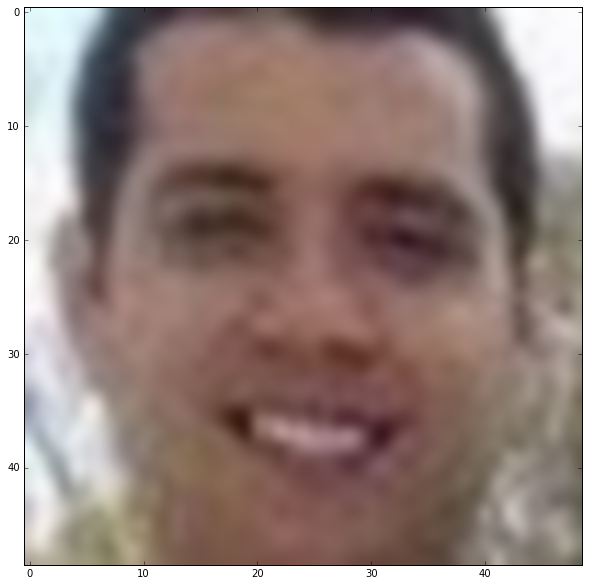

In [9]:
image = caffe.io.load_image('tmp.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

In [10]:
net.blobs['data'].data[...] = transformed_image

output = net.forward()

output_prob = output['prob'][0]

print 'predicted class is:', output_prob.argmax()

labels_file = '../vgg16_training/labels'
    
labels = np.loadtxt(labels_file, str, delimiter='\n')

print 'output label:', labels[output_prob.argmax()]

predicted class is: 4
output label: (25, 32)


In [11]:
top_inds = output_prob.argsort()[::-1][:3]

print 'probabilites and labels:'
zip(output_prob[top_inds], labels[top_inds])

probabilites and labels:


[(0.99874014, '(25, 32)'),
 (0.00089020637, '(38, 43)'),
 (0.00034772558, '(15, 20)')]

In [ ]:
%timeit net.forward()

### 5. Examining Intermediate output

In [12]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 224, 224)
conv1_1	(1, 64, 224, 224)
conv1_2	(1, 64, 224, 224)
pool1	(1, 64, 112, 112)
conv2_1	(1, 128, 112, 112)
conv2_2	(1, 128, 112, 112)
pool2	(1, 128, 56, 56)
conv3_1	(1, 256, 56, 56)
conv3_2	(1, 256, 56, 56)
conv3_3	(1, 256, 56, 56)
pool3	(1, 256, 28, 28)
conv4_1	(1, 512, 28, 28)
conv4_2	(1, 512, 28, 28)
conv4_3	(1, 512, 28, 28)
pool4	(1, 512, 14, 14)
conv5_1	(1, 512, 14, 14)
conv5_2	(1, 512, 14, 14)
conv5_3	(1, 512, 14, 14)
pool5	(1, 512, 7, 7)
fc6	(1, 4096)
fc7	(1, 4096)
fc8-8	(1, 8)
prob	(1, 8)


In [ ]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape)

In [13]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* First we'll look at the first layer filters, conv1

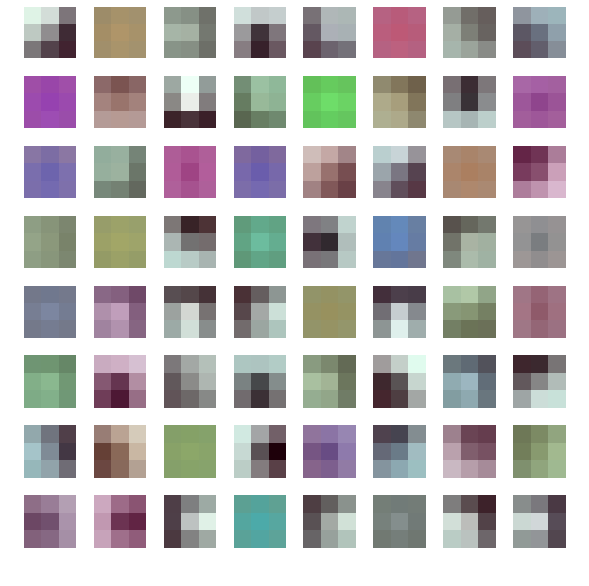

In [17]:
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

* Display first 36 feature maps of the 6th convolutional layer.

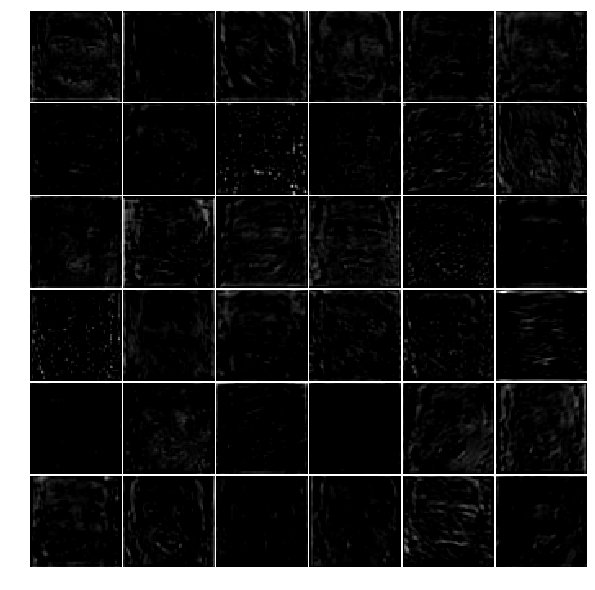

In [18]:
feat = net.blobs['conv3_2'].data[0, :36]
vis_square(feat)

['(0, 2)' '(4, 6)' '(8, 12)' '(15, 20)' '(25, 32)' '(38, 43)' '(48, 53)'
 '(60, 100)']


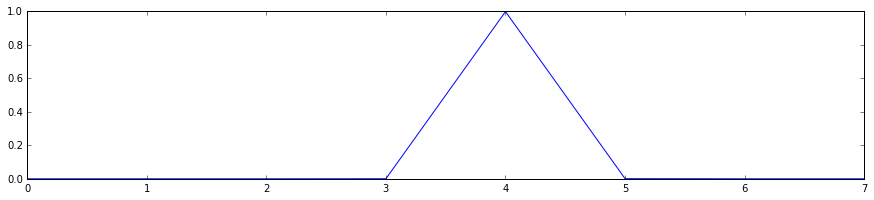

In [19]:
print labels

feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

In [ ]:
# download an image
my_image_url = ""  # paste your URL here
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])